# Boltzmann equations in our model

## Imports and definitions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint, quad, solve_ivp
from scipy.interpolate import interp1d
from IPython.display import display, Markdown
from scipy.special import kn #modified Bessel function of the second kind, order n
import time
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator,NullFormatter,LogLocator)
majorFormatter = FormatStrFormatter('%d')
from f import odeint_steps_coupled, sci_notation
import csv
from matplotlib.lines import Line2D
from multiprocessing import Process, Value
import math

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)

In [2]:
path = '/home/mar/Desktop/Master Thesis/Calculations/WIMP_Boltzmann_eq_solution/dof_table' 

#Ojo que luego el de lambda creo que no es g_star_s, en mi deducción es g_star_s / sqrt(g_star)
mx = 5
T_MeV = np.loadtxt(path)[:,0]
g_star_data = np.loadtxt(path)[:,8]

T_GeV = T_MeV / 1000 #Temperature in GeV
x_interp = mx / T_GeV

g_star =  interp1d(x_interp, g_star_data, bounds_error=False, fill_value='nan', kind='linear') 

In [3]:
mN = 2

In [4]:
gx = 1
gN = 2
Mpl = 2.435e18 #GeV

def lambda_(x):
    return 4*np.pi / np.sqrt(90) * mx * Mpl * np.sqrt(g_star(x))

def P(x):
    T=mx/x
    return  +(gx/gN)**2 * (mx/mN)**4 * (kn(2, x)/kn(2, mN/T))**2

Equilibrium distributions in the Maxwell-Boltzmann approximation (for the initial condition)

$$Y_{\chi,\chi^\ast} ^{\rm eq} = \frac{45}{4\pi^4}\frac{g_\chi}{g_{\star s}}x^2 K_2(x){\rm e}^{\pm \xi_{\chi}}$$

$$Y_{N,\bar N} ^{\rm eq} = \frac{45}{4\pi^4}\frac{g_N}{g_{\star s}}x^2 K_2(x){\rm e}^{\pm \xi_{ N}}$$


with $\xi = \mu / T$, and 

$$2 \sinh \xi_\chi = \frac{Y_{\Delta \chi}}{Y_{\chi}^{\rm eq}(\Delta \chi=0)}\,,$$

$$2 \sinh \xi_N = \frac{Y_{\Delta N}}{Y_{N}^{\rm eq}(\Delta N=0)}\,.$$


In [5]:
#Equilibrium distributions: (If T_DS=T_SM, then the x and the g_star are the same as for the SM)

def Yeq0(g, x):
    return g*45/(4*np.pi**4) * x**2 / g_star(x) * kn(2,x)

def xi(x, YD, g):
    return np.arcsinh(YD / (2*Yeq0(g, x)))

def Yxeq(x, YDx):
    return Yeq0(gx, x) * np.exp(xi(x, YDx, gx))

def Ykeq(x, YDx):
    return Yeq0(gx, x) * np.exp(-xi(x, YDx, gx))

def YNeq(x, YDN): #Careful, we are taking x of mx and not of mN
    return Yeq0(gN, x) * np.exp(xi(x, YDN, gN))

def YMeq(x, YDN):
    return Yeq0(gN, x) * np.exp(-xi(x, YDN, gN))

## Thermally averaged cross-sections:

In [7]:
with open("Files/ThAvCrossSection_x.csv") as file:
    csvreader = csv.reader(file)
    x_table = np.array(list(csvreader)).astype(float)[0]
    
with open("Files/ThAvCrossSection_Annihilation.csv") as file:
    csvreader = csv.reader(file)
    sigmav_ann_table = np.array(list(csvreader)).astype(float)[0]
    
with open("Files/ThAvCrossSection_Scattering.csv") as file:
    csvreader = csv.reader(file)
    sigmav_scatt_table = np.array(list(csvreader)).astype(float)[0]   /   8 #Factor 8
    
x_table_extended = np.append(1e-10, x_table)
sigmav_ann_table_extended = np.append(sigmav_ann_table[0], sigmav_ann_table)
sigmav_scatt_table_extended = np.append(sigmav_scatt_table[0], sigmav_scatt_table)

sigmav_ann_interp = interp1d(np.log10(x_table_extended), np.log10(sigmav_ann_table_extended), kind='linear')   
sigmav_scatt_interp = interp1d(np.log10(x_table_extended), np.log10(sigmav_scatt_table_extended), kind='linear')

def sigma_ann(x, Lambda):
    return 10**sigmav_ann_interp(np.log10(x)) / Lambda**2

def sigma_scatt(x, Lambda2):
    return 10**sigmav_scatt_interp(np.log10(x))/ Lambda2**2

def sigma_ann_swave(Lambda):
    return (mx**2 - mN**2)**(3/2) / (4*np.pi * Lambda**2 * mx**3)

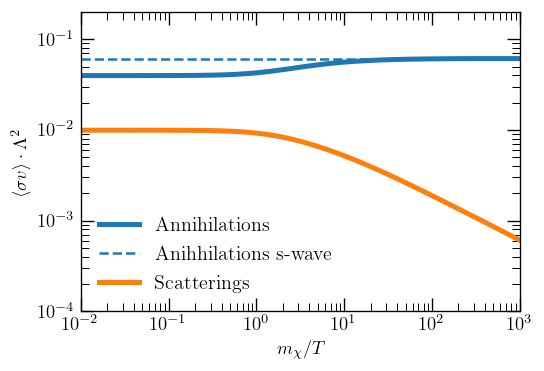

In [8]:
x_plot = np.logspace(-2, 3, 100)

fig, ax = plt.subplots(figsize=(4.72, 4.72*(0.7)), dpi=120)

plt.loglog(x_plot, sigma_ann(x_plot, 1), linewidth=3, label='Annihilations')
plt.loglog(x_plot, sigma_ann_swave(1)*np.ones(len(x_plot)), '--', color='tab:blue', linewidth=1.5, label=r'Anihhilations s-wave') #  $\chi N \to \chi^\ast \overline{N} $')

plt.loglog(x_plot, sigma_scatt(x_plot, 1), linewidth=3, label=r'Scatterings') #  $\chi N \to \chi^\ast \overline{N} $')

plt.legend(loc=0, prop={'size': 12}, frameon=False)

plt.tick_params(which='both', bottom=True, top=True, left=True, right=True)
plt.tick_params(axis='both', which='major', direction='in', length = 8, labelsize=11)
plt.tick_params(axis='both', which='minor', direction='in', length = 5, labelsize=11)

plt.xlim(0.01, 1000)
plt.ylim(1e-4, 2e-1)
plt.xlabel(r'$m_\chi/T$', fontsize=11)
plt.ylabel(r'$\langle \sigma v \rangle \cdot \Lambda^2$', fontsize=11)

# plt.savefig('Plots/Thermally_Averaged_CrossSections.pdf', bbox_inches='tight')
# plt.savefig('Latex/Thermally_Averaged_CrossSections.pdf', bbox_inches='tight', transparent=True)

plt.show()

In [9]:
def sigma_Nd_ud(s, M_Phi, y, g):
#     Lambda_n = M_Phi / np.sqrt(y*g)
    return y**2*g**2*(mN**2+14*s)/(192*np.pi*M_Phi**4)

def sigma_Nu_dd(s, M_Phi, y, g):
#     Lambda_n = M_Phi / np.sqrt(y*g)
    return y**2*g**2*(2*mN**2+s)/(192*np.pi*M_Phi**4)

def lambd_Kallen(a, b, c):
    return (a-b-c)**2 - 4*b*c

def thermal_average_integral_scattering(s, T, m1, m2, M_Phi, sigma_scatt):
    return s**(3/2) * kn(1, np.sqrt(s) / T) * lambd_Kallen(1, m1**2/s,  m2**2/s) * sigma_scatt(s, M_Phi, y, g)

def s_lim_integration(m1, m2, M_Phi, T, sigma_scatt):
    s = (m1+m2)**2
    init_value = thermal_average_integral_scattering(s*1.04, T, m1, m2, M_Phi, sigma_scatt)
    result = 1
    if init_value > 1e-30:
        while (np.abs(result) > 1e-40):
            s = s * 1.05
            result = thermal_average_integral_scattering(s, T, m1, m2, M_Phi, sigma_scatt)
        return s / 1.05
    else:
        while (np.abs(result) > init_value*1e-30):
                s = s * 1.05
                result = thermal_average_integral_scattering(s, T, m1, m2, M_Phi, sigma_scatt)
        return s / 1.05 + 4

def averaged_cross_section_T(T, m1, sigma_scatt):
    integral, err = quad(thermal_average_integral_scattering, (m1+m2)**2, s_lim_integration(m1, m2, M_Phi, T, sigma_scatt), args=(T, m1, m2, M_Phi, sigma_scatt,), epsabs=1.49e-16, epsrel=1.49e-5, limit=15000)
    return integral

def averaged_cross_section_scattering(m1, m2, sigma_scatt):
    g1 = 2
    g2 = 2
    averaged_cross_section = np.zeros(len(xxs))
    i = 0
    for x in xxs:
        T = m1/x
        n_eq_1 = g1 / (2 * np.pi**2) * m1**2 * T * kn(2, m1/T)
        n_eq_2 = g2 / (2 * np.pi**2) * m2**2 * T * kn(2, m2/T)
        integral = averaged_cross_section_T(T, m1, sigma_scatt)
#         print(integral, (kn(2, m1/T)))
        averaged_cross_section[i] = integral * g1 * g2 * T / (32 * np.pi**4) / (n_eq_1 * n_eq_2)
        i+=1
    averaged_cross_section_interp =  interp1d(xxs, averaged_cross_section, bounds_error=False, fill_value='nan', kind='linear') 
    return averaged_cross_section_interp

def averaged_cross_section_scattering_func(func_interp, x):
    return 10**func_interp(np.log10(x))


In [10]:
mN = 1
m1 = mN
m2 = 1e-6
M_Phi = 1e3

xxs = np.logspace(-6, 3, 10)

y = 1
g = 1

sigmav_Nd_ud = averaged_cross_section_scattering(m1, m2, sigma_Nd_ud)
sigmav_Nu_dd = averaged_cross_section_scattering(m1, m2, sigma_Nu_dd)

Lambda_n = M_Phi / np.sqrt(y*g)

<ipython-input-9-b2a2908d112a>:45: RuntimeWarning: invalid value encountered in double_scalars
  averaged_cross_section[i] = integral * g1 * g2 * T / (32 * np.pi**4) / (n_eq_1 * n_eq_2)


## Equations:

In [6]:
def eqs_xtot_Ntot_Dx(x, Ys): # Approximation that YDN is negligible because always compared to YNtot

    T = mx / x
    
    Yxtot, YNtot, YDx = Ys
    
    Yx = Yxtot/2 + YDx/2
    Yk = Yxtot/2 - YDx/2
    YN = YNtot/2 + 11/122*YDx/2
    YM = YNtot/2 - 11/122*YDx/2
    
    
    f = [-lambda_(x) / x**2 *(+ 2 *  sigma_ann(x, Lambda0)   * (Yx*Yk-P(x)*YN*YM) 
                              + 2 *  sigma_ann(x, Lambda2)   * (Yx**2 + Yk**2 - P(x)* (YN**2 + YM**2))),
         -lambda_(x) / x**2 *(- 2 *  sigma_ann(x, Lambda0)   * (Yx*Yk-P(x)*YN*YM) 
                              - 2 *  sigma_ann(x, Lambda2)   * (Yx**2 + Yk**2 - P(x)* (YN**2 + YM**2))),
         -lambda_(x) / x**2 *(+ 2 *  sigma_ann(x, Lambda2)   * (Yx**2 - Yk**2 + P(x)* (YN**2 - YM**2))
                              + 2 *  sigma_scatt(x, Lambda2) * (Yx*YN - Yk*YM))
        ]
    
    return f

In [12]:
x = np.logspace(-3, 3, 100000)

Lambda0 = 1e4
Lambda2 = 6e90

#initial condition:
Y_Dx_in = 8.7e-11
Y_x_total = Yxeq(x[0], Y_Dx_in)+ Ykeq(x[0], Y_Dx_in)
Y_N_total = YNeq(x[0], 0)      + YMeq(x[0], 0)
Y0s = [Y_x_total, Y_N_total, Y_Dx_in]

#Solving the differential equation:
Ysol, fo = odeint(eqs_xtot_Ntot_Dx, Y0s, x, tfirst=True, atol=1e-18, rtol=1e-3, full_output=1)
print(fo['message'])

Y_x_tot_interp = interp1d(x, Ysol[:, 0], bounds_error=False, fill_value='nan', kind='linear') 
Y_N_tot_interp = interp1d(x, Ysol[:, 1], bounds_error=False, fill_value='nan', kind='linear') 
Y_Dx_interp = interp1d(x, Ysol[:, 2], bounds_error=False, fill_value='nan', kind='linear') 

def Yx(x):
    return Y_x_tot_interp(x)/2 + Y_Dx_interp(x)/2

def Yk(x):
    return Y_x_tot_interp(x)/2 - Y_Dx_interp(x)/2

def YN(x):
    return Y_N_tot_interp(x)/2

def YM(x):
    return Y_N_tot_interp(x)/2

Integration successful.


In [10]:
#Equilibrium of our system taking Lambda0<<Lambda2:

def Yxeq_here(x):
    return (Yx(x)-Yk(x))/2 + np.sqrt( ((Yx(x)-Yk(x)) / 2)**2 + P(x)*YN(x)*YM(x))
                                     
def Ykeq_here(x):
    return -(Yx(x)-Yk(x))/2 + np.sqrt( ((Yx(x)-Yk(x)) / 2)**2 + P(x)*YN(x)*YM(x))

In [11]:
def Ykeq_here_simpl_Lambda2inf(x, Y_Dx_in):
    return -(Y_Dx_in)/2 + np.sqrt( ((Y_Dx_in) / 2)**2 + P(x)*YNeq(1e-2,0)*YMeq(1e-2,0))

## Numerical integration

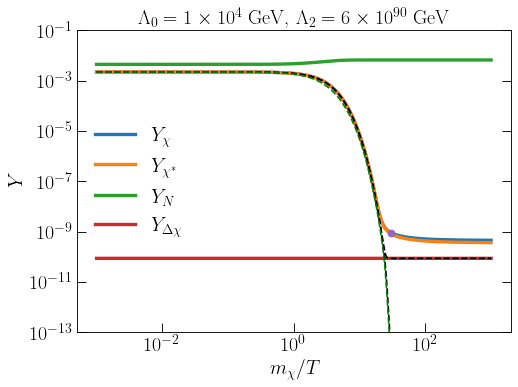

In [15]:
x_plot = np.logspace(np.log10(x[0]), 3, 10000)

fig, ax = plt.subplots(1, 1, figsize=(7,5), dpi=80)

plt.plot(x_plot, Yx(x_plot), linewidth=3, label=(r'$Y_{\chi}$'))
plt.plot(x_plot, Yk(x_plot), linewidth=3, label=(r'$Y_{\chi^\ast}$'))
plt.plot(x_plot, YN(x_plot), linewidth=3, label=(r'$Y_{N}$'))

plt.plot(x_plot, Yx(x_plot)-Yk(x_plot), linewidth=3, label=(r'$Y_{\Delta \chi}$'))

plt.plot(x_plot, Yxeq_here(x_plot), '--k')
plt.plot(x_plot, Ykeq_here(x_plot), '--k')
plt.plot(x_plot, Ykeq_here_simpl_Lambda2inf(x_plot, Yx(x_plot)-Yk(x_plot)), '--g')

# plt.plot(x_plot, Yxeq(x_plot, Yx(x_plot)-Yk(x_plot)), '--b')
# plt.plot(x_plot, Ykeq(x_plot, Yx(x_plot)-Yk(x_plot)), '--b')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc=0, prop={'size': 18}, frameon=False)

plt.title(r'$\Lambda_0 = {}$ GeV,   $ \Lambda_2 = {}$ GeV'.format(sci_notation(Lambda0), sci_notation(Lambda2)), fontsize=18)

plt.tick_params(which='both', bottom=True, top=False, left=True, right=True)
plt.tick_params(axis='both', which='major', direction='in', length = 8, labelsize=18)
plt.tick_params(axis='both', which='minor', direction='in', length = 5, labelsize=18)

# plt.xlim(0.07, 1000)
plt.ylim(1e-13, 1e-1)
plt.xlabel(r'$m_\chi/T$', fontsize=18)
plt.ylabel(r'$Y$', fontsize=18)
plt.plot(30,  Yx(30), 'o')
plt.show()

## Comparison to instantaneous freeze-out approximation

### Definitions

In [12]:
def Delta(x):
    Y1 = Yx(1e-2) + Yk(1e-2) + YN(1e-2) + YM(1e-2)
#     Y1 = 2* 0.00397508634087937
    sigma0 = sigma_ann_swave(Lambda0)
    num = x**2 * (1 - mN/mx) * P(x) * Y1**2
    den = 2 * (Y_DN_in**2 /4 + P(x) * Y1**2) * lambda_(x) * sigma0
    return num / den

def T_in_finder(mN):

    T_in_tentative = 0.51787 * gN**(2/5) * mN / g_star(mN)**(2/5)
#     print(mN,  g_star(mN), T_in_tentative)
    T_in3 = 0.51787 * gN**(2/5) * mN / g_star(T_in_tentative)**(2/5)
#     print(mN, g_star(T_in_tentative), T_in3)
    T_in = 0.51787 * gN**(2/5) * mN / g_star(T_in3)**(2/5)
#     print(mN, g_star(T_in3), T_in)
    return T_in

def lambda_EMD(x, T_in_EMD):
#     T_in = T_in_finder(mN)
#     x_in = mx/T_in
    return 4*np.pi / np.sqrt(90) * (mx)**(3/2) * Mpl * np.sqrt(g_star(T_in_EMD)) / np.sqrt(T_in_EMD)

def Delta_EMD(x, T_in_EMD):
    Y1 = Yx(x) + Yk(x) + YN(x) + YM(x)
    sigma0 = sigma_ann_swave(Lambda0)
    num = x**2 * (1 - mN/mx) * P(x) * Y1**2
    den = 2 * (Y_DN_in**2 /4 + P(x)*Y1**2) * lambda_EMD(x, T_in_EMD) * sigma0
    return num / den

def Delta_Drees(x):
    P_drees = Yeq0(gx, x)**2
    sigma0 = sigma_ann_swave(Lambda0)
    num =  2* x**2 * P_drees
    den = (Y_DN_in**2 + 4* P_drees) * lambda_(x) * sigma0
    return num / den
 
def xf_Drees_approx(x_f0, Lambda0): #Feed Drees x_f0
    sigma0 = sigma_ann_swave(Lambda0)
    return x_f0 * (1 +  0.285* lambda_(20) * sigma0 * Y_DN_in / x_f0**3)

def x_f0_Kolb(Lambda0):
    sigma0 = sigma_ann_swave(Lambda0)
    n = 0
    g_star = 84
    term1 = np.log(0.038 * (n+1) * (gx/g_star**(1/2)) * Mpl * mx *  sigma0)
    term2 = - (n + 1/2) * np.log( np.log(0.0038*(n+1)* (gx/g_star**(1/2)) *  Mpl * mx *  sigma0) )
    return term1 + term2

### Plot

In [17]:
Y_DN_in = 8.7e-11
x_find = np.linspace(1, 70, 1000)

    
# def Ykeq_here_Lambda2inf(x):
# #     Y1 = Yx(x) + Yk(x) + YN(x) + YM(x)
#     return -(Y_DN_in)/2 + np.sqrt( (Y_DN_in / 2)**2 + P(x)*YNeq(x,0)*YMeq(x,0))

def Ykeq_here_Lambda2inf(x):
    Y1 = 2* 0.00397508634087937

    return -(Y_DN_in)/2 + np.sqrt( ((Y_DN_in) / 2)**2 + P(x)*Y1**2)


T_in_EMD = T_in_finder(mN)

i = 0
Lambda0s_ =  np.logspace(2, 6.7, 100)
x_f_vect = np.zeros(len(Lambda0s_))
x_f_vect_D = np.zeros(len(Lambda0s_))
x_f_vect_EMD = np.zeros(len(Lambda0s_))

factor = np.sqrt(2)-1

for Lambda0 in Lambda0s_:
#     index_min = np.nanargmin(np.abs(Delta(x_find)/Ykeq_here_Lambda2inf(x_find) - factor))
    index_min = np.nanargmin(np.abs(Delta(x_find)/Ykeq(x_find, Y_DN_in) - factor))

    index_min_D = np.nanargmin(np.abs(Delta_Drees(x_find)/Ykeq(x_find, Y_DN_in) - factor))
    index_min_EMD = np.nanargmin(np.abs(Delta_EMD(x_find, T_in_EMD)/Ykeq_here_Lambda2inf(x_find) - factor))

    x_f_vect[i] = x_find[index_min]
    x_f_vect_D[i] = x_find[index_min_D]
    x_f_vect_EMD[i] = x_find[index_min_EMD]
    i += 1 

<ipython-input-17-89afe99303e5>:30: RuntimeWarning: divide by zero encountered in divide
  index_min_EMD = np.nanargmin(np.abs(Delta_EMD(x_find, T_in_EMD)/Ykeq_here_Lambda2inf(x_find) - factor))


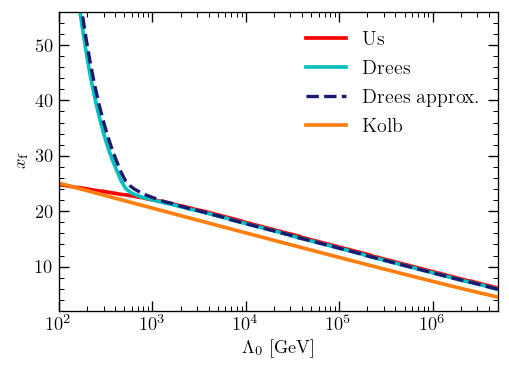

In [18]:
fig, ax = plt.subplots(figsize=(0.8*5.9, 0.8*5.9*(0.7)), dpi=120)

plt.plot(Lambda0s_, x_f_vect, '-r', linewidth = 2.2, label='Us')    
# plt.plot(Lambda0s_, x_f_vect_EMD, '-m', linewidth = 2.2, label='Us EMD')    
plt.plot(Lambda0s_, x_f_vect_D, '-', color='c', linewidth = 2.2, label='Drees')
plt.plot(Lambda0s_, xf_Drees_approx(x_f_vect_D, Lambda0s_), '--', color='midnightblue', linewidth=2, label='Drees approx.')
# plt.plot(Lambda0s_, xf_Drees_approx(x_f0_Kolb(Lambda0s_), Lambda0s_), '--', color='peru', linewidth=2, label='Drees approx.')
plt.plot(Lambda0s_[:], x_f0_Kolb(Lambda0s_[:]), '-', color='tab:orange', linewidth=2.2, label='Kolb')

# ax.vlines(1e4, 1, 53, color='k', linewidth=0.7)
# ax.hlines(10, 70, 7e6, color='k', linewidth=0.7)

locmin_y = MultipleLocator(2)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(NullFormatter())

plt.tick_params(which='both', bottom=True, top=True, left=True, right=True)
plt.tick_params(axis='both', which='major', direction='in', length = 6, labelsize=11)
plt.tick_params(axis='both', which='minor', direction='in', length = 3, labelsize=11)

plt.xlim(100, 5e6)
plt.ylim(2, 56)
# plt.xlim(80, 6e6)
# plt.ylim(2, 52)
plt.xlabel(r'$\Lambda_0$ [GeV]', fontsize=11)
plt.ylabel(r'$x_{\rm f}$', fontsize=11)

# plt.legend(loc=5, frameon=False, bbox_to_anchor=(1.5, 0.5))
plt.legend(loc=0, frameon=False)

# plt.grid(linewidth=0.3) 
plt.xscale('log')
# plt.savefig('Plots/xf_2.pdf', bbox_inches='tight')

## Comparison between freeze out in radiation dominated era or matter dominated era

### Boltzmann equations

In [19]:
# Our case:

def eqs_xtot_Ntot_Dx_fo(x, Ys): # Aproximation that YDN is cero because always is very small compared to YNtot 

    T = mx / x
    
    Yxtot, YNtot = Ys
    
    Yx = Yxtot/2 + YDx/2
    Yk = Yxtot/2 - YDx/2
    YN = YNtot/2 + YDx/2
    YM = YNtot/2 - YDx/2
    
    
    f = [-lambda_(x) / x**2 *(+ 2 *  sigma_ann(x, Lambda0)   * (Yx*Yk-P(x)*YN*YM)),
         -lambda_(x) / x**2 *(- 2 *  sigma_ann(x, Lambda0)   * (Yx*Yk-P(x)*YN*YM)),
        ]
    
    return f

# Case in the paper of Drees et. al:

def eqs_xtot_Ntot_Dx_Drees(x, Ys): # Aproximation that YDN is cero because always is very small compared to YNtot 

    T = mx / x
    
    Yxtot, YNtot = Ys
    
    Yx = Yxtot/2 + YDx/2
    Yk = Yxtot/2 - YDx/2
    YN = YNtot/2 + YDx/2
    YM = YNtot/2 - YDx/2
    
    
    f = [-lambda_(x) / x**2 *(+ 2 *  sigma_ann(x, Lambda0)   * (Yx*Yk-Yxeq(x, YDx)*Ykeq(x, YDx))),
         -lambda_(x) / x**2 *(- 2 *  sigma_ann(x, Lambda0)   * (Yx*Yk-Yxeq(x, YDx)*Ykeq(x, YDx))),
        ]
    
    return f

In [20]:
def lambda_EMD(x):
    T_in_EMD = T_in_finder(mN)
    return 4*np.pi / np.sqrt(90) * (mx)**(3/2) * Mpl * np.sqrt(g_star(T_in_EMD)) / np.sqrt(T_in_EMD)

def lambda_RD(x):
    return 4*np.pi / np.sqrt(90) * mx * Mpl * np.sqrt(g_star(x))

def T_in_finder(mN):

    T_in_tentative = 0.51787 * gN**(2/5) * mN / g_star(mN)**(2/5)
#     print(mN,  g_star(mN), T_in_tentative)
    T_in3 = 0.51787 * gN**(2/5) * mN / g_star(T_in_tentative)**(2/5)
#     print(mN, g_star(T_in_tentative), T_in3)
    T_in = 0.51787 * gN**(2/5) * mN / g_star(T_in3)**(2/5)
#     print(mN, g_star(T_in3), T_in)
    return T_in

### Integration:

In [21]:
x = np.logspace(-3, 2.5, 100000)

Lambda0 = 1e4

#initial condition:
YDx = 8.7e-12
Y_x_total = Yxeq(x[0], YDx) + Ykeq(x[0], YDx)
Y_N_total = YNeq(x[0], 0)   + YMeq(x[0], 0)
Y0s = [Y_x_total, Y_N_total]

#Solving the differential equation:
lambda_= lambda_RD
Ysol_RD, fo = odeint(eqs_xtot_Ntot_Dx_fo, Y0s, x, tfirst=True, atol=1e-18, rtol=1e-3, full_output=1)
print(fo['message'])

lambda_= lambda_EMD
Ysol_EMD, fo = odeint(eqs_xtot_Ntot_Dx_fo, Y0s, x, tfirst=True, atol=1e-18, rtol=1e-3, full_output=1)
print(fo['message'])

lambda_= lambda_RD
Ysol_Drees, fo = odeint(eqs_xtot_Ntot_Dx_Drees, Y0s, x, tfirst=True, atol=1e-16, rtol=1e-3, full_output=1)
print(fo['message'])

Y_x_tot_interp_1 = interp1d(x, Ysol_RD[:, 0], bounds_error=False, fill_value='nan', kind='linear') 
Y_N_tot_interp_1 = interp1d(x, Ysol_RD[:, 1], bounds_error=False, fill_value='nan', kind='linear') 

Y_x_tot_interp_2 = interp1d(x, Ysol_EMD[:, 0], bounds_error=False, fill_value='nan', kind='linear') 
Y_N_tot_interp_2 = interp1d(x, Ysol_EMD[:, 1], bounds_error=False, fill_value='nan', kind='linear') 

Y_x_tot_interp_3 = interp1d(x, Ysol_Drees[:, 0], bounds_error=False, fill_value='nan', kind='linear') 
Y_N_tot_interp_3 = interp1d(x, Ysol_Drees[:, 1], bounds_error=False, fill_value='nan', kind='linear') 


def Yx1(x):
    return Y_x_tot_interp_1(x)/2 + YDx/2

def Yk1(x):
    return Y_x_tot_interp_1(x)/2 - YDx/2


def Yx2(x):
    return Y_x_tot_interp_2(x)/2 + YDx/2

def Yk2(x):
    return Y_x_tot_interp_2(x)/2 - YDx/2


def Yx3(x):
    return Y_x_tot_interp_3(x)/2 + YDx/2

def Yk3(x):
    return Y_x_tot_interp_3(x)/2 - YDx/2

Integration successful.
Integration successful.
Integration successful.


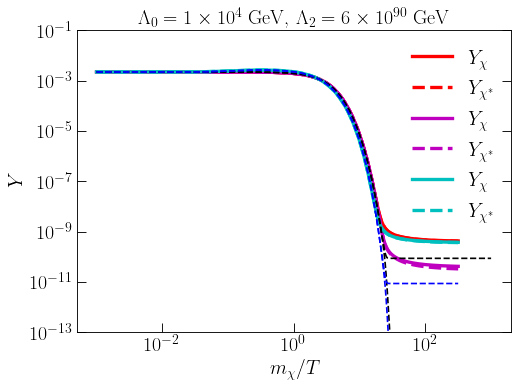

In [22]:
x_plot = np.logspace(np.log10(x[0]), 3, 10000)

fig, ax = plt.subplots(1, 1, figsize=(7,5), dpi=80)

plt.plot(x_plot, Yx1(x_plot), 'r-', linewidth=3, label=(r'$Y_{\chi}$'))
plt.plot(x_plot, Yk1(x_plot), 'r--', linewidth=3, label=(r'$Y_{\chi^\ast}$'))
plt.plot(x_plot, Yx2(x_plot), 'm-',linewidth=3, label=(r'$Y_{\chi}$'))
plt.plot(x_plot, Yk2(x_plot), 'm--',linewidth=3, label=(r'$Y_{\chi^\ast}$'))
plt.plot(x_plot, Yx3(x_plot), 'c-',  linewidth=3, label=(r'$Y_{\chi}$'))
plt.plot(x_plot, Yk3(x_plot),  'c--', linewidth=3, label=(r'$Y_{\chi^\ast}$'))
# plt.plot(x_plot, YN(x_plot), linewidth=3, label=(r'$Y_{N}$'))

# plt.plot(x_plot, Yx(x_plot)-Yk(x_plot), linewidth=3, label=(r'$Y_{\Delta \chi}$'))

plt.plot(x_plot, Yxeq_here(x_plot), '--k')
plt.plot(x_plot, Ykeq_here(x_plot), '--k')
# plt.plot(x_plot, Ykeq_here_simpl_Lambda2inf(x_plot, Yx(x_plot)-Yk(x_plot)), '--g')

plt.plot(x_plot, Yxeq(x_plot, Yx1(x_plot)-Yk1(x_plot)), '--b')
plt.plot(x_plot, Ykeq(x_plot, Yx1(x_plot)-Yk1(x_plot)), '--b')

plt.xscale('log')
plt.yscale('log')
plt.legend(loc=0, prop={'size': 18}, frameon=False)

plt.title(r'$\Lambda_0 = {}$ GeV,   $ \Lambda_2 = {}$ GeV'.format(sci_notation(Lambda0), sci_notation(Lambda2)), fontsize=18)

plt.tick_params(which='both', bottom=True, top=False, left=True, right=True)
plt.tick_params(axis='both', which='major', direction='in', length = 8, labelsize=18)
plt.tick_params(axis='both', which='minor', direction='in', length = 5, labelsize=18)

# plt.xlim(0.07, 1000)
plt.ylim(1e-13, 1e-1)
plt.xlabel(r'$m_\chi/T$', fontsize=18)
plt.ylabel(r'$Y$', fontsize=18)
# plt.plot(30,  Yx(30), 'o')
plt.show()

### Scan and comparison plot:

In [ ]:
# Y_DN_in = 8.7e-11

#initial condition:
YDx = 8.7e-11
Y_x_total = Yxeq(x[0], YDx)+ Ykeq(x[0], YDx)
Y_N_total = YNeq(x[0],   0)+ YMeq(x[0],   0)
Y0s = [Y_x_total, Y_N_total]

i = 0
Lambda0s_ =  np.logspace(2, 6.7, 100)
x_f_vect = np.zeros(len(Lambda0s_))
x_f_vect_D = np.zeros(len(Lambda0s_))
x_f_vect_EMD = np.zeros(len(Lambda0s_))

for Lambda0 in Lambda0s_:

    #Solving the differential equation:
    lambda_= lambda_RD
    Ysol_RD, fo1 = odeint(eqs_xtot_Ntot_Dx_fo, Y0s, x, tfirst=True, atol=1e-15, rtol=1e-3, full_output=1)
    print(fo1['message'])

    if fo1['message']=='Integration successful.':
        x_f_vect[i] = Ysol_RD[-1, 0]/2 + YDx/2
        print('Good')
    else:
        x_f_vect[i] = np.nan
#         print('mal')
        
    lambda_= lambda_EMD
    Ysol_EMD, fo2 = odeint(eqs_xtot_Ntot_Dx_fo, Y0s, x, tfirst=True, atol=1e-15, rtol=1e-3, full_output=1)
    print(fo2['message'])

            
    if fo2['message']=='Integration successful.':
        x_f_vect_EMD[i] = Ysol_EMD[-1, 0]/2 + YDx/2
        print('Good')
    else:
        x_f_vect_EMD[i] = np.nan
            
    
    lambda_= lambda_RD
    Ysol_Drees, fo3 = odeint(eqs_xtot_Ntot_Dx_Drees, Y0s, x, tfirst=True, atol=1e-14, rtol=1e-2, full_output=1)
    print(fo3['message'])


    if fo3['message']=='Integration successful.':
        x_f_vect_D[i] = Ysol_Drees[-1, 0]/2 + YDx/2
        print('Good')
    else:
        x_f_vect_D[i] = np.nan
    
    
    i += 1 

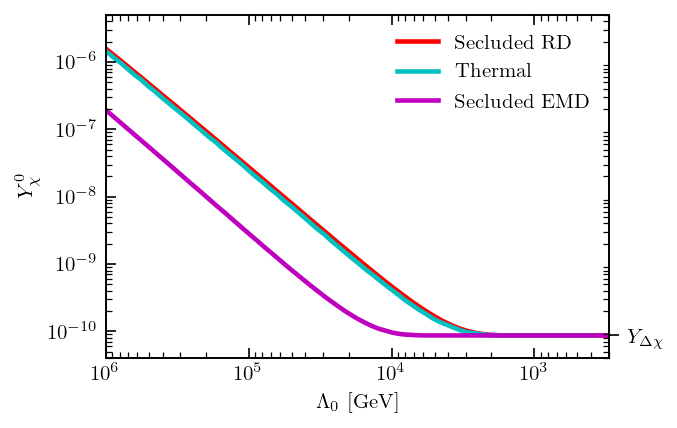

In [24]:
fig, ax = plt.subplots(figsize=(4.33, 4.33*(0.7)), dpi=150)

# Graficar las líneas principales

ax.loglog(Lambda0s_[np.isnan(x_f_vect)==False], x_f_vect[np.isnan(x_f_vect)==False],
          '-r', linewidth=2.2, label='Secluded RD', zorder=1.2)    
ax.plot(Lambda0s_[np.isnan(x_f_vect_D)==False], x_f_vect_D[np.isnan(x_f_vect_D)==False], 
        '-', color='c', linewidth=2.2, label='Thermal', zorder=1.2)
ax.plot(Lambda0s_[np.isnan(x_f_vect_EMD)==False], x_f_vect_EMD[np.isnan(x_f_vect_EMD)==False],
        '-m', linewidth=2.2, label='Secluded EMD', zorder=1.2)    


# Minor ticks y formateadores
locmin_y = MultipleLocator(2)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(NullFormatter())

# Configuración de ticks para ax
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', length=5, labelsize=10)
ax.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=10)

# Eje derecho (ax2) compartiendo el mismo eje x
ax2 = ax.twinx()

# Configurar ambos ejes en logarítmico
ax.set_yscale('log')
ax2.set_yscale('log')

# Configuración de ticks en el eje derecho
# Copiar los mismos ticks que el eje izquierdo
ax2.tick_params(axis='both', which='major', direction='in', length=5, labelsize=10)
ax2.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=10)

# Agregar el tick personalizado hacia afuera en ax2
ax2.set_yticks([8.7e-11])
ax2.set_yticklabels([r'$Y_{\Delta \chi}$'], fontsize=10)
ax2.tick_params(axis='y', which='major', direction='out', color='black', labelsize=10)


# Configuración de límites y etiquetas
ax.set_xlim(1e6, 300)
ax.set_ylim(4e-11, 0.5e-5)
ax.set_xlabel(r'$\Lambda_0$ [GeV]', fontsize=10)
ax.set_ylabel(r'$Y^0_\chi$', fontsize=10)

# Hacer coincidir los límites de y entre ax y ax2
ax2.set_ylim(ax.get_ylim())
 
# Leyenda
ax.legend(loc=0, frameon=False, fontsize=10)

# Escalas logarítmicas en el eje x
ax.set_xscale('log')

# Guardar el gráfico
# plt.savefig('/home/mar/Dropbox/Thesis/Figures/RelicAbundanceFreezeOut.pdf', bbox_inches='tight')


## Freeze out into light $S$

### Boltzmann equations

In [26]:
def eqs_xtot_S(x, Ys): # Aproximando que la YDN es cero porque siempre es peq compararo con YNtot y no vamos 
                             # a mirar su evolución
#     T = mx / x
    xDS = x/0.46
    
    Yxtot, YS = Ys
    
    Yx = Yxtot/2 + YDx/2
    Yk = Yxtot/2 - YDx/2 
    
    sigma_ann = 1e-9 * (lambdaSX/6e-4)**2 #GeV^-2

    f = [-lambda_(x) / x**2 *(+ 2 *  sigma_ann  * (Yx*Yk - Yxeq(xDS, YDx)*Ykeq(xDS, YDx)/Yeq0(1, 0.000000001)**2  * YS**2 )),
         -lambda_(x) / x**2 *(- 2 *  sigma_ann  * (Yx*Yk - Yxeq(xDS, YDx)*Ykeq(xDS, YDx)/Yeq0(1, 0.000000001)**2  * YS**2 )),
        ]
    
    return f


### Integration and plot

In [ ]:
x = np.logspace(-3, 2, 100000)


YDx = 2.3e-10
Y_x_total = Yxeq(x[0], YDx)+ Ykeq(x[0], YDx)
Y0s = [Y_x_total, Yeq0(1, 0.000000001)]

lambdaSXs = np.logspace(-7, -2, 50)

Yxtot_fin = np.zeros(len(lambdaSXs))
i=0
for lambdaSX in lambdaSXs:
    
    print(lambdaSX, 1e-9 * (lambdaSX/6e-4)**2)

    #Solving the differential equation:
    lambda_= lambda_RD
    Ysol_S, fo = odeint(eqs_xtot_S, Y0s, x, tfirst=True, atol=1e-15, rtol=1e-5, full_output=1)
    print(fo['message'])

    
    if fo['message']=='Integration successful.':
        Yxtot_fin[i] = Ysol_S[-1, 0]
        print('Good')
    else:
        Yxtot_fin[i] = np.nan
#         print('mal')
    
    
    Y_x_tot_interp = interp1d(x, Ysol_S[:, 0], bounds_error=False, fill_value='nan', kind='linear') 
    Y_S_tot_interp = interp1d(x, Ysol_S[:, 1], bounds_error=False, fill_value='nan', kind='linear') 
    def Yxtot(x):
        return Y_x_tot_interp(x)
    def YS(x):
        return Y_S_tot_interp(x)

    x_plot = np.logspace(np.log10(x[0]), 3, 10000)
    plt.loglog(x_plot, Yxtot(x_plot), 'r-', linewidth=2, label=(r'$Y_{\chi}^{\rm tot}$'))
    plt.loglog(x_plot, 2*YS(x_plot), 'b-', linewidth=2, label=(r'$Y_{S}$'))
    plt.loglog(x_plot, YDx*np.ones(len(x_plot)),'k--', linewidth=2, label=(r'$Y_{S}$'))

    plt.show()

    
    
    
    i+=1

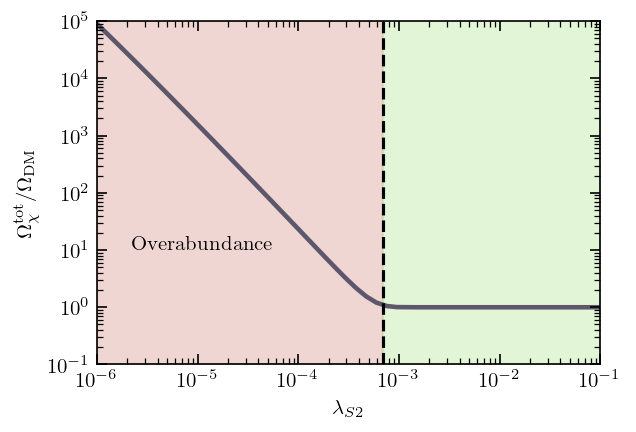

In [31]:
fig, ax = plt.subplots(figsize=(4.33, 4.33*(0.7)), dpi=150)

# Graficar las líneas principales

lambdaSXs_plot = np.append(lambdaSXs[np.isnan(Yxtot_fin)==False], 1e-1)
Yxtot_fin_plot = np.append(Yxtot_fin[np.isnan(Yxtot_fin)==False], YDx)


ax.loglog(lambdaSXs_plot, Yxtot_fin_plot/YDx, '-', color = '#5D576B', linewidth=2.2, zorder=1.2)    

ax.vlines(7e-4, 1e-1, 1e6, linestyle='dashed', color='k')

plt.fill_betweenx(np.array([0.1, 1e5]), 1e-6,  7e-4, color='#CE796B', alpha=0.3)
plt.fill_betweenx(np.array([0.1, 1e5]), 7e-4,  1e-1, color='#C6ECAE', alpha=0.5)

ax.text( 2.2e-6, 10, r'Overabundance', fontsize=10)

# Minor ticks y formateadores
locmin_y = MultipleLocator(2)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(NullFormatter())

# Configuración de ticks para ax
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax.tick_params(axis='both', which='major', direction='in', length=5, labelsize=10)
ax.tick_params(axis='both', which='minor', direction='in', length=3, labelsize=10)


# Configurar ambos ejes en logarítmico
ax.set_yscale('log')

# Configuración de límites y etiquetas
ax.set_xlim(1e-6, 1e-1)
ax.set_ylim(0.1, 1e5)
ax.set_xlabel(r'$\lambda_{S2}$', fontsize=10)
ax.set_ylabel(r'$\Omega_{\chi}^{\rm tot}/\Omega_{\rm DM}$', fontsize=10)


# Leyenda
# ax.legend(loc=0, frameon=False, fontsize=10)

# Escalas logarítmicas en el eje x
ax.set_xscale('log')

# Guardar el gráfico
plt.savefig('/home/mar/Dropbox/Thesis/Figures/RelicAbundanceS.pdf', bbox_inches='tight')


## Analysis of washout

### Analytical approximation for washout

In [13]:
# def Y_Dchi_approx(x, x0, Y_Dx_in):
#     Y1 = Yxeq(x0, Y_Dx_in)+ Ykeq(x0, Y_Dx_in) + YNeq(x0, Y_Dx_in)+ YMeq(x0, Y_Dx_in)
#     return Y_Dx_in * np.exp(0.05 * lambda_(x) / Lambda2**2 * Y1 * (1/x - 1/x0) )

def Y_Dchi_approx(x, x0, Y_Dx_in):
#     Y1 = Yxeq(x0, Y_Dx_in)+ Ykeq(x0, Y_Dx_in) + YNeq(x0, Y_Dx_in)+ YMeq(x0, Y_Dx_in)
    return Y_Dx_in * np.exp( 15/(16*np.pi) * lambda_(x) / Lambda2**2 * Yxeq(x0, 0) * (1/x - 1/x0) )

def Y_Dchi_approx(x, x0, Y_Dx_in):
#     Y1 = Yxeq(x0, Y_Dx_in)+ Ykeq(x0, Y_Dx_in) + YNeq(x0, Y_Dx_in)+ YMeq(x0, Y_Dx_in)
    return Y_Dx_in * np.exp( 1275/(1952*np.pi) * lambda_(x) / Lambda2**2 * Yxeq(x0, 0) * (1/x - 1/x0) )

### Numerical integration and comparison

In [15]:
Lambda0 = 1e100
Lambda2s = [2.5e10, 2.9e10, 4e10, 6.5e10, 1e11]

x = np.logspace(-3, 2.5, 100000)

#initial condition:
Y_Dx_in = 1e-10
Y_x_total = Yxeq(x[0], Y_Dx_in) + Ykeq(x[0], Y_Dx_in)
Y_N_total = YNeq(x[0], 0)       + YMeq(x[0], 0)
Y0s = [Y_x_total, Y_N_total, Y_Dx_in]

Tin = 1e5
x = np.logspace(np.log10(mx/Tin), -2, 100000)

YDx_data = np.zeros((len(Lambda2s), len(x)))
i = 0
for Lambda2 in Lambda2s:

#Solving the differential equation:
    Ysol, fo = odeint(eqs_xtot_Ntot_Dx, Y0s, x, tfirst=True, atol=1e-17, rtol=1e-3, full_output=1)
    print(fo['message'])

    YDx_data[i] = Ysol[:,2]
    
    i+=1

Integration successful.
Integration successful.
Integration successful.
Integration successful.
Integration successful.


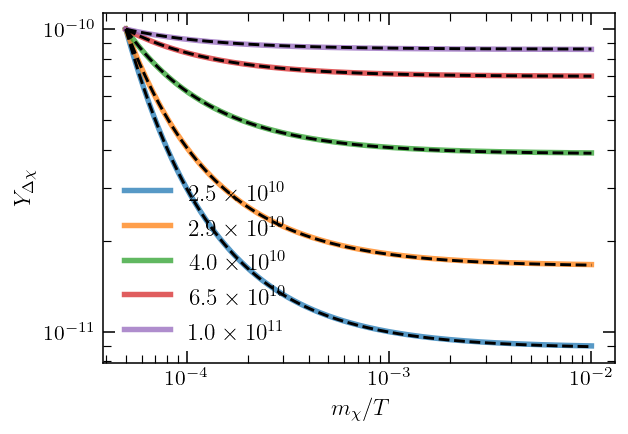

In [16]:
fig, ax = plt.subplots(figsize=(4.72, 4.72*(0.7)), dpi=140)

x_plot = np.logspace(np.log10(x[0]), np.log10(x[-1]), 100)

i=0
for Lambda2 in Lambda2s:
    plt.loglog(x, YDx_data[i], linewidth=2.8, alpha=0.75, label=r'${}$'.format(sci_notation(Lambda2, 1)))
    plt.loglog(x_plot, Y_Dchi_approx(x_plot, x[0], Y_Dx_in), '--k', linewidth=1.5, zorder=3)#, label=r'High $T$ approx.')
    i+=1

plt.tick_params(which='both', bottom=True, top=True, left=True, right=True)
plt.tick_params(axis='both', which='major', direction='in', length = 6, labelsize=11)
plt.tick_params(axis='both', which='minor', direction='in', length = 4, labelsize=11)
ax.set_xlabel(r'$m_{\chi}/T$', fontsize=12)
ax.set_ylabel(r'$Y_{\Delta \chi}$', fontsize=12)
ax.legend(loc=0, prop={'size': 12}, frameon=False)

# plt.xlim(7e-6, 10**(-2))
# plt.ylim(1e-17, 1e-9)

plt.show()

In [17]:
Y_Dx_in_new = Y_Dx_in/((YDx_data[:,-1])/(8.7e-11))

i = 0
for Lambda2 in Lambda2s:
#Solving the differential equation:
    Y0s = [Y_x_total, Y_N_total, Y_Dx_in_new[i]]

    Ysol, fo = odeint(eqs_xtot_Ntot_Dx, Y0s, x, tfirst=True, atol=1e-18, rtol=1e-3, full_output=1)
    print(fo['message'])
    
    YDx_data[i] = Ysol[:,2]
    
    i+=1

Integration successful.
Integration successful.
Integration successful.
Integration successful.
Integration successful.


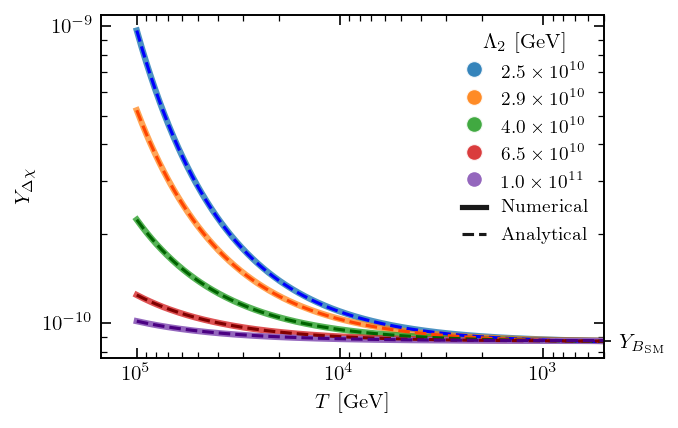

In [19]:
fig, ax = plt.subplots(figsize=(4.33, 4.33*(0.7)), dpi=150)
x_plot = np.logspace(np.log10(x[0]), -1.3, 100)
T_plot = mx/x_plot
T = mx/x
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']
colors2 = ['blue', 'orangered', 'darkgreen', 'maroon', 'indigo']
alphas = [0.8, 0.7, 0.8, 0.8, 1]
i=0
for Lambda2 in Lambda2s:
    plt.loglog(T, YDx_data[i], linewidth=3, color=colors[i], alpha=alphas[i])#, label=r'$\Lambda_2={}$ GeV'.format(sci_notation(Lambda2, 1)))
    plt.loglog(T_plot, Y_Dchi_approx(x_plot, x[0], Y_Dx_in_new[i]), '--', color=colors2[i], linewidth=1.5, zorder=3)#, label=r'High $T$ approx.')
    i+=1


plt.xlim(1.5e5, 5e2)
# ax.set_ylim(6e-11, 1e-2)

ax2 = ax.twinx()
ax2.loglog(x, YDx_data[0], linewidth=0)
ax2.set_yticks([8.7e-11])
ax2.set_yticklabels([r'$Y_{B_{\rm SM}}$'], fontsize=10)
ax2.tick_params(axis='y', which='major', direction='out', color='black', labelsize=10)

ax2.set_ylim(ax.get_ylim())

ax.set_xlabel(r'$T$ [GeV]', fontsize=10)
ax.set_ylabel(r'$Y_{\Delta \chi}$', fontsize=10)

    
legend_elements =  [Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[0], alpha=0.9, markersize=8, label=r'${}$'.format(sci_notation(Lambda2s[0], 1))),
                Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[1], alpha=0.9, markersize=8, label=r'${}$'.format(sci_notation(Lambda2s[1], 1))),
               Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[2], alpha=0.9, markersize=8, label=r'${}$'.format(sci_notation(Lambda2s[2], 1))),
                 Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[3], alpha=0.9, markersize=8, label=r'${}$'.format(sci_notation(Lambda2s[3], 1))),
                Line2D([0], [0], color='w', marker='o', markerfacecolor=colors[4], alpha=1, markersize=8, label=r'${}$'.format(sci_notation(Lambda2s[4], 1))),
                   Line2D([0], [0], color='k', alpha=0.9, linewidth=2.5, label='Numerical'),
                    Line2D([0], [0], linestyle='dashed', alpha=0.9,  color='k', linewidth=1.5, label='Analytical')]

legend = plt.legend(ncol=1, handles=legend_elements, handlelength=1.3, loc=0, prop={'size': 9}, frameon=False, title=r'$\Lambda_2$ [GeV]')
title = legend.get_title()
title.set_fontsize(10)

    
ax.tick_params(which='both', bottom=True, top=True, left=True, right=True)
ax2.tick_params(which='minor', bottom=False, top=False, left=False, right=False)

ax.tick_params(axis='both', which='major', direction='in', length = 5, labelsize=10)
ax.tick_params(axis='both', which='minor', direction='in', length = 3, labelsize=10)
locmin = LogLocator(base=10, subs=(0.1, ), numticks=100)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(NullFormatter())


locmin_y = LogLocator(base=10.0, subs=np.linspace(0, 1.0, 11), numticks=1000)
locmin_x =   LogLocator(base=10.0, subs=np.linspace(0, 1.0, 11), numticks=1000)
ax.yaxis.set_minor_locator(locmin_y)
ax.yaxis.set_minor_formatter(NullFormatter())


ax.xaxis.set_minor_locator(locmin_x)
ax.xaxis.set_minor_formatter(NullFormatter())


# ax.set_rasterized(True)



# plt.savefig('Plots/Y4BoltzmannEquationAlone.pdf', bbox_inches='tight', transparent=True)
plt.savefig('/home/mar/Dropbox/Thesis/Figures/WashoutDifferentLambda2s.pdf', bbox_inches='tight', transparent=True)

plt.show()